### Imports

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

from pycaret.regression import *

In [8]:
# plot two features against each other
def plot_jointplot(data, x, y):
    r, p = sp.stats.pearsonr(data[x], data[y])

    jgrid = sns.jointplot(data=data, x=x, y=y, kind='reg')
    jgrid.ax_joint.text(
        1, 1, 
        f"r={r:.2f}, p={p:.2e}",
        horizontalalignment='right',
        transform = jgrid.ax_joint.transAxes
    )

    jgrid.figure.show()

In [9]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

### Plots

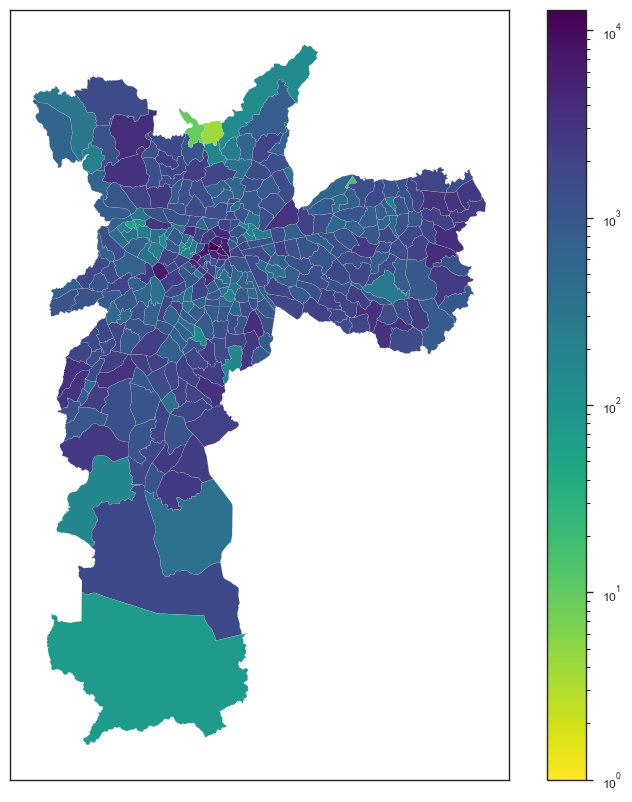

In [10]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


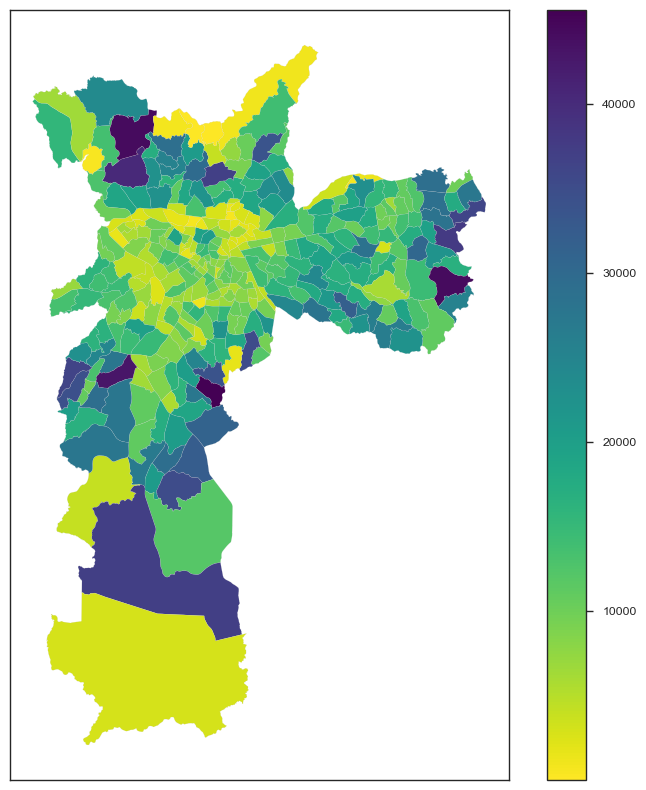

In [11]:
data.plot(
    column='V001_BASICO',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
)

plt.xticks([])
plt.yticks([])

plt.show()


### Regression

In [12]:
data.dropna(inplace=True)
data.shape

(338, 78)

In [13]:
features_to_drop = [
    'NumeroZona',
    'NomeZona',
    'NumeroMuni',
    'NomeMunici',
    'NumDistrit',
    'NomeDistri',
    'geometry',
    'crimes',
]

features = [feature for feature in data.columns.to_list() if feature not in features_to_drop]
data = data[features + ['crimes']]
data.shape

(338, 71)

### Exploring the connection between crime and other variables

#### CENSUS Variables

In [14]:
df = data[[
    'Area_ha_2', 'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01',
    'V004_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO',
    'V001_DOMICILIO02', 'V002_DOMICILIO02', 'V001_DOMICILIO01',
    'V002_DOMICILIO01', 'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03',
    'V002_PESSOA03', 'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03',
    'V006_PESSOA03', 'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
    'V001_RESPONSAVEL02', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
    'V004_DOMICILIORENDA', 'V003_BASICO', 'V005_BASICO', 'V007_BASICO',
    'V009_BASICO', 'V011_BASICO', 'crimes'
]]

df.shape

(338, 33)

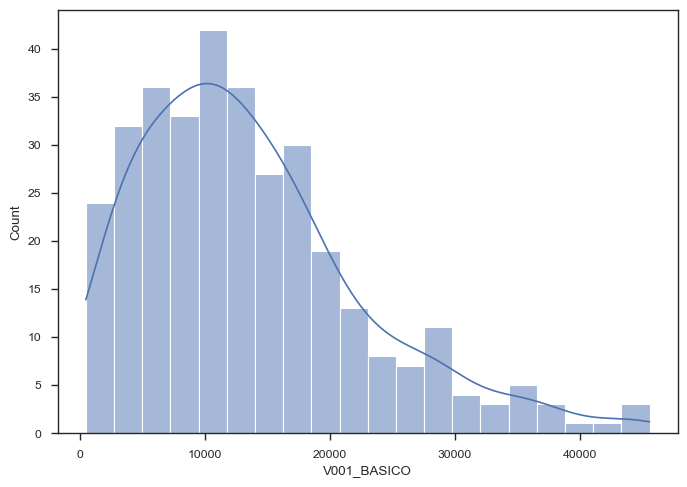

In [15]:
ax = sns.histplot(data=df, x='V001_BASICO', bins=20, kde=True)

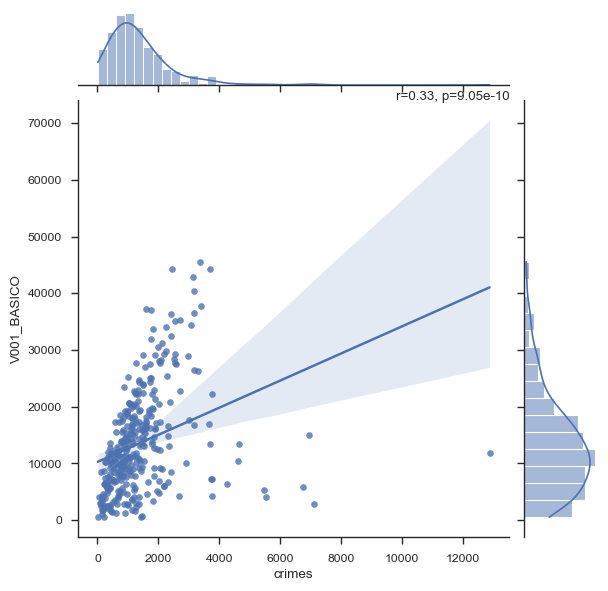

In [16]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

<Axes: xlabel='crimes'>

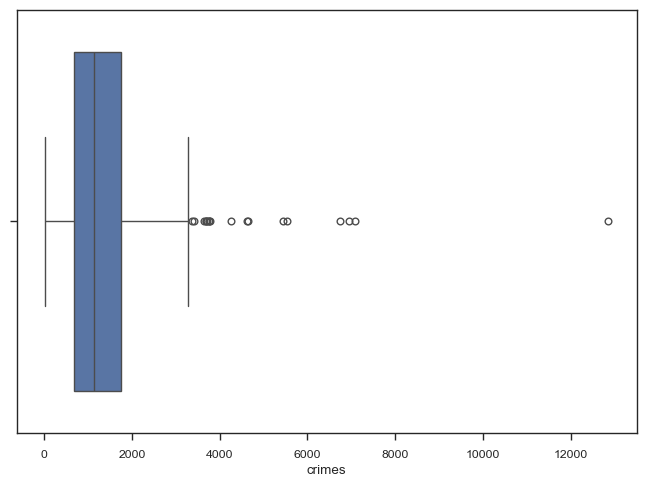

In [17]:
sns.boxplot(data=df, x='crimes')

In [18]:
# remove outliers based on the IQR
Q1 = df['crimes'].quantile(0.25)
Q3 = df['crimes'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['crimes'] < (Q1 - 1.5 * IQR)) | (df['crimes'] > (Q3 + 1.5 * IQR)))]

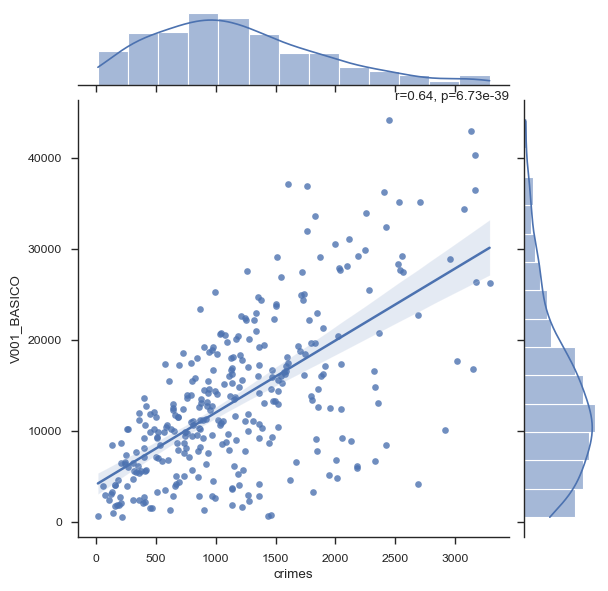

In [19]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [20]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_DOMICILIO01,0.645286
V001_RESPONSAVEL02,0.644804
V001_ENTORNO01,0.644135
V001_BASICO,0.644135
V002_DOMICILIO01,0.644135
V001_RESPONSAVEL01,0.642564
V086_PESSOA02,0.638032
V001_PESSOA01,0.636880
V001_PESSOA03,0.635256


In [21]:
# it seems to be a lot of multicollinearity with V001_BASICO
# Domicílios particulares permanentes ou pessoas responsáveis por domicílios particulares permanentes

corr_matrix['V001_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V001_BASICO
V001_ENTORNO01,1.000000
V001_BASICO,1.000000
V002_DOMICILIO01,1.000000
V001_RESPONSAVEL02,0.999985
V001_DOMICILIO01,0.999756
V001_PESSOA01,0.994071
V001_PESSOA12,0.992527
V001_RESPONSAVEL01,0.992402
V086_PESSOA02,0.991135
V001_DOMICILIO02,0.989741


In [22]:
df = df.loc[:, (df.columns == 'V001_BASICO') | (corr_matrix['V001_BASICO'] < 0.8)]

In [23]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_BASICO,0.644135
V003_ENTORNO01,0.331328
V002_DOMICILIORENDA,0.279409
V003_DOMICILIORENDA,0.279287
V005_BASICO,0.262166
V007_BASICO,0.257443
V011_BASICO,0.255587
V009_BASICO,0.255210
V006_PESSOA03,0.234571


<Axes: >

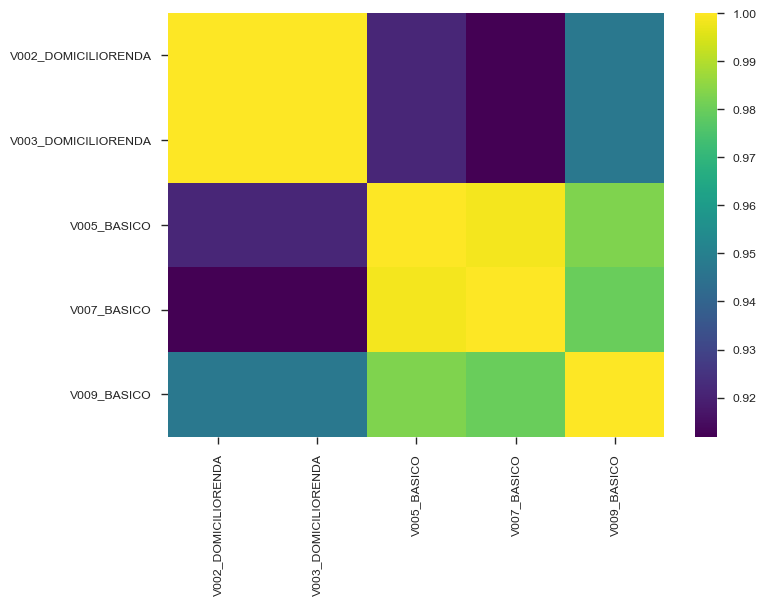

In [24]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cols = (corr_matrix.mask(mask) > .8).any()
sns.heatmap(corr_matrix.loc[cols, cols], cmap='viridis')

In [25]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['V005_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V005_BASICO
V005_BASICO,1.000000
V007_BASICO,0.998299
V011_BASICO,0.991890
V009_BASICO,0.983010
V003_DOMICILIORENDA,0.921244
V002_DOMICILIORENDA,0.921208
V003_BASICO,0.664677
V003_ENTORNO01,0.396441
V001_BASICO,0.383068
crimes,0.262166


In [26]:
df = df.loc[:, (df.columns == 'V005_BASICO') | (corr_matrix['V005_BASICO'] < 0.8)]

In [27]:
df.columns

Index(['Area_ha_2', 'V003_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO',
       'V004_PESSOA03', 'V006_PESSOA03', 'V004_DOMICILIORENDA', 'V003_BASICO',
       'V005_BASICO', 'crimes'],
      dtype='object')

In [4]:
!pip install tpot

  Using cached TPOT-0.12.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached deap-1.4.1.tar.gz (1.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached stopit-1.1.2.tar.gz (18 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached TPOT-0.12.2-py3-none-any.whl (87 kB)
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)
  Created wheel for deap: filename=deap-1.4.1-py3-none-any.whl size=97350 sha256=a78f761822b242add1a006616ea723d8f0d7de7e504e3e749446c05307a5f4fe
  Stored in directory: c:\users\arthu\appdata\local\pip\cache\wheels\f8\64\b8\65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-a

In [7]:
from tpot import TPOTRegressor

In [ ]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='crimes'), df['crimes'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

In [28]:
reg1 = setup(
    data=df,
    target='crimes',
    session_id=0,

    normalize=True,
    normalize_method='zscore',
    
    transformation=False,
    transformation_method='yeo-johnson',

    transform_target=True,
    transform_target_method='yeo-johnson',

    feature_selection=True,
    feature_selection_method='sequential',
    feature_selection_estimator='lr',
    n_features_to_select=5,
)

,Description,Value
0,Session id,0
1,Target,crimes
2,Target type,Regression
3,Original data shape,"(320, 10)"
4,Transformed data shape,"(320, 6)"
5,Transformed train set shape,"(224, 6)"
6,Transformed test set shape,"(96, 6)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [ ]:
get_config('X_train_transformed').columns

In [ ]:
get_config('y_train_transformed')

In [29]:
create_model('lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:59:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
           ^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 589, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 589, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\utils\parallel.py", line 129, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\model_selection\_validation.py", line 917, in _fit_and_score
    test_scores = _score(
                  ^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\pycaret\internal\patches\sklearn.py", line 153, in wrapper
    if len(args[0]) > 1:  # Has transformers
       ^^^^^^^^^^^^
TypeError: object of type 'LinearRegression' has no len()
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\pycaret\internal\pipeline.py", line 273, in fit
    X, y, _ = self._fit(X, y, routed_params)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\pycaret\internal\pipeline.py", line 249, in _fit
    fitted_transformer = self._memory_fit(
                         ^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\pycaret\internal\pipeline.py", line 69, in _fit_one
    transformer.fit(*args)
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\pycaret\internal\preprocess\transformers.py", line 229, in fit
    self.transformer.fit(*args, **fit_params)
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\feature_selection\_sequential.py", line 251, in fit
    new_feature_idx, new_score = self._get_best_new_feature_score(
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\feature_selection\_sequential.py", line 282, in _get_best_new_feature_score
    scores[feature_idx] = cross_val_score(
                          ^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\model_selection\_validation.py", line 719, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\model_selection\_validation.py", line 430, in cross_validate
    results = parallel(
              ^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\sklearn\utils\parallel.py", line 67, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 1952, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 1595, in _get_outputs
    yield from self._retrieve()
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 1699, in _retrieve
    self._raise_error_fast()
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 1734, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 736, in get_result
    return self._return_or_raise()
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\joblib\parallel.py", line 754, in _return_or_raise
    raise self._result
TypeError: object of type 'LinearRegression' has no len()


In [ ]:
best_model = compare_models()

In [ ]:
best_model

### PyCaret

In [311]:
data = df

In [ ]:
reg1 = setup(
    data = data,
    target = 'crimes',
    train_size = 0.8,

    # remove_multicollinearity = True,

    #normalize = True,
    #normalize_method = 'zscore',

    #transformation = True,
    #transformation_method = 'yeo-johnson',

    #transform_target = True,
    #transform_target_method='yeo-johnson',

    #remove_outliers = True,

    #feature_selection = True,
    #feature_selection_method = 'univariate',
    #n_features_to_select = 20,
    #feature_selection_estimator = 'rf',

    #fold_strategy = cv,

    verbose = True,
    session_id = 123,
)

In [ ]:
best = compare_models()

### Add Spacial Lag

In [ ]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
wq  = weights.contiguity.Rook.from_dataframe(data)
w_kernel = weights.distance.Kernel.from_dataframe(data)

In [ ]:
f, axs = plt.subplots(figsize=(10, 10))

ax = data.plot(
    edgecolor="k", facecolor="w", ax=axs
)

knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)

axs.axis([-46.6, -46.8, -23.7, -23.6]);
axs.set_axis_off()

In [ ]:
gdf_lag = (
    data[features]
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(wq, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

In [ ]:
gdf_lag.shape

In [ ]:
gdf_lag.isna().sum()

In [ ]:
# data = data[features + ['crimes']].join(gdf_lag)
# data.columns